# Analysis of AirBnB Dataset
**Goal:** Predict the **Price** of an AirBnB listing in Barcelona based on its characteristics.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from src.regression_tree import RegressionTree
from src.random_forest import RandomForest
from src.utils import evaluate_model

# Set plot style
sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
# Load the dataset
file_path = os.path.join('..', 'data', 'Cleaned_airbnb_barcelona.csv')
df_raw = pd.read_csv(file_path)

print(f"Original Shape: {df_raw.shape}")
df_raw.head()

Original Shape: (19833, 25)


,Unnamed: 0,id,host_id,host_is_superhost,host_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,...,amenities,price,minimum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,review_scores_rating
0,0,18666,71615,f,45.0,Sant Martí,8026,41.40889,2.18555,Apartment,...,"['TV', 'Internet', 'Wifi', 'Air conditioning',...",$130.00,3,t,0,0,0,182,0,80.0
1,1,18674,71615,f,45.0,La Sagrada Família,8025,41.40420,2.17306,Apartment,...,"['TV', 'Internet', 'Wifi', 'Air conditioning',...",$60.00,1,t,3,20,50,129,10,87.0
2,2,21605,82522,f,2.0,Sant Martí,8018,41.40560,2.19821,Apartment,...,"['TV', 'Wifi', 'Kitchen', 'Paid parking off pr...",$33.00,2,t,4,8,15,15,36,90.0
3,3,23197,90417,t,5.0,Sant Martí,8930,41.41203,2.22114,Apartment,...,"['TV', 'Internet', 'Wifi', 'Wheelchair accessi...",$210.00,3,t,11,33,63,318,16,95.0
4,4,25786,108310,t,1.0,Vila de Gràcia,8012,41.40145,2.15645,Apartment,...,"['TV', 'Wifi', 'Air conditioning', 'Kitchen', ...",$45.00,1,t,8,19,41,115,49,95.0


## Preprocessing

In [3]:
# search for missing values
df_raw.isna().sum()

Unnamed: 0                  0
id                          0
host_id                     0
host_is_superhost          34
host_listings_count        34
neighbourhood              10
zipcode                   604
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   9
bedrooms                    3
beds                       34
amenities                   0
price                       0
minimum_nights              0
has_availability            0
availability_30             0
availability_60             0
availability_90             0
availability_365            0
number_of_reviews_ltm       0
review_scores_rating     4847
dtype: int64

In [4]:
def preprocess_airbnb(df):
    df = df.copy()
    
    # Drop non-predictive columns
    df = df.drop(columns=['Unnamed: 0','id', 'host_id'], errors='ignore')
    
    # Handle Missing Categorical Values
    miss_categorical = ['host_is_superhost', 'neighbourhood', 'zipcode']
    for c in miss_categorical:
        df[c] = df[c].fillna('None')

    # Handle Missing Numerical Values
    # use median to fill in missing values (not mean, so outliers don't distort)
    # for 'review_scores_rating' additionally perserve information which ones were missing since there so many
    # might be relevent if no reviews score rating
    miss_numerical = ['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating']

    df['review_scores_rating_missing'] = df['review_scores_rating'].isna().astype(int)

    for n in miss_numerical:
        df[n] = df[n].fillna(df[n].median())
    
    # Handle 'amenities'
    # select only the 30 most common amenities to reduce runtime
    df['amenities'] = df['amenities'].astype(str)
    df['amenities'] = (
        df['amenities']
            .str.replace('[', '', regex=False)
            .str.replace(']', '', regex=False)
            .str.replace("'", '', regex=False)
    )
    
    amenities_dummies = df['amenities'].str.get_dummies(sep = ',')

    amenity_counts = amenities_dummies.sum().sort_values(ascending=False)
    top_30 = amenity_counts.head(30).index

    print(top_30)

    top_30_dummies = amenities_dummies[top_30]
    df = pd.concat([df.drop(columns = 'amenities'), top_30_dummies], axis = 1)
    
    # Handle Categoricals
    cols_to_encode = ['neighbourhood', 'property_type', 'zipcode', 'property_type', 'room_type', 'host_is_superhost']
    existing_cols = [c for c in cols_to_encode if c in df.columns]
    
    df = pd.get_dummies(df, columns=existing_cols, drop_first=True, dtype=int)

    df['has_availability'] = df['has_availability'].map({'t': 1, 'f': 0})

    # Handle 'price'
    df['price'] = df['price'].astype(str)
    df['price'] = (
        df['price']
            .str.replace('$', '', regex=False)
            .str.replace('.00', '', regex=False)
            .str.replace(',', '', regex=False)
    )

    df['price'] = df['price'].astype(float)
    
    return df

# 4. Apply and Inspect
df_clean = preprocess_airbnb(df_raw)

print("Original Shape:", df_raw.shape)
print("Cleaned Shape: ", df_clean.shape)
print("\nFirst 5 rows of cleaned data:")
display(df_clean.head())

Index([' Essentials', ' Kitchen', ' Hangers', ' Hair dryer', ' Washer',
       ' Heating', ' Wifi', ' Iron', 'TV', ' Shampoo', ' Elevator',
       ' Hot water', ' Air conditioning', ' Laptop friendly workspace',
       ' Refrigerator', ' Dishes and silverware', ' Host greets you',
       ' Bed linens', ' Microwave', ' Family/kid friendly', ' Coffee maker',
       ' Cooking basics', ' Oven', ' Stove', ' Dryer',
       ' Long term stays allowed', ' Smoking allowed',
       ' Paid parking off premises', 'Wifi', ' First aid kit'],
      dtype='object')
Original Shape: (19833, 25)
Cleaned Shape:  (19833, 294)

First 5 rows of cleaned data:


,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,has_availability,...,property_type_Nature lodge,property_type_Other,property_type_Serviced apartment,property_type_Tiny house,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t
0,45.0,41.40889,2.18555,6,1.0,2.0,4.0,130.0,3,1,...,0,0,0,0,0,0,0,0,1,0
1,45.0,41.40420,2.17306,8,2.0,3.0,6.0,60.0,1,1,...,0,0,0,0,0,0,0,0,1,0
2,2.0,41.40560,2.19821,2,1.0,1.0,1.0,33.0,2,1,...,0,0,0,0,0,0,1,0,1,0
3,5.0,41.41203,2.22114,6,2.0,3.0,8.0,210.0,3,1,...,0,0,0,0,0,0,0,0,0,1
4,1.0,41.40145,2.15645,2,1.0,1.0,1.0,45.0,1,1,...,0,0,0,0,0,0,1,0,0,1


In [5]:
# check again for missing values
missing = df_clean.isna().sum()
missing[missing > 0]

Series([], dtype: int64)

## Data Split


In [6]:
target_col = 'price'

X = df_clean.drop(columns=[target_col]).values

y = df_clean[target_col].values

print(f"Feature Matrix X shape: {X.shape}")
print(f"Target Vector y shape:  {y.shape}")

Feature Matrix X shape: (19833, 477)
Target Vector y shape:  (19833,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples:     {X_test.shape[0]} (Locked away)")

Training Samples: 15866
Test Samples:     3967 (Locked away)


## Training and Evaluation

In [8]:
from src.regression_tree import RegressionTree
from src.random_forest import RandomForest
from src.utils import evaluate_model, add_runtime, print_runtimes
from src.utils import print_results
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 1. EVALUATE REGRESSION TREE
# (Assuming your class uses 'min_samples_split' and 'max_depth')

start_training_rt = time.time()
tree_model = RegressionTree(min_samples_split=10, max_depth=5)
duration_training_rt= time.time() - start_training_rt
add_runtime("Training Regression Tree Airbnb",duration_training_rt)

start_evaluation_rt = time.time()
tree_results = evaluate_model(tree_model, X_train, y_train, X_test, y_test)
duration_evaluation_rt= time.time() - start_evaluation_rt
add_runtime("Evaluation Regression Tree Airbnb",duration_evaluation_rt)

print_results("REGRESSION TREE", tree_results)

# 2. EVALUATE RANDOM FOREST
# (Note: Using 'seed' as per your previous message)

start_training_rf = time.time()
rf_model = RandomForest(n_trees=20, max_depth=5, seed=123)
duration_training_rf= time.time() - start_training_rf
add_runtime("Training Random Forest Airbnb",duration_training_rf)

start_evaluation_rf = time.time()
rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test)
duration_evaluation_rf= time.time() - start_evaluation_rf
add_runtime("Evaluation Random Forest Airbnb",duration_evaluation_rf)

print_results("RANDOM FOREST", rf_results)
print_runtimes()

# 3. VISUAL COMPARISON
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Tree Results
sns.scatterplot(x=tree_results['y_test_actual'], y=tree_results['y_test_pred'], ax=axes[0], color='orange', alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title(f"Tree (Test R²: {tree_results['Test_R2']:.2f})")
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")

# Plot Forest Results
sns.scatterplot(x=rf_results['y_test_actual'], y=rf_results['y_test_pred'], ax=axes[1], color='green', alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title(f"Forest (Test R²: {rf_results['Test_R2']:.2f})")
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Comparison to Existing Implementations

We use the the default parameters for the existing techniques. Hence, the regression tree uses parameters `criterion='squared_error'` and `min_samples_split=2` and the random forest `criterion='squared_error'` and `n_estimators=100`.

The performance metrics for comparision are MSE/RMSE and $R^2$.

--- REGRESSION TREE existing ---
  CV MSE (Error):    9.2715
  CV R² (Stability):    0.9749
  Test MSE (Error):     9.4362
  Test RMSE (Error):    3.0718
  Test R² (Accuracy):   0.9741
------------------------------
--- RANDOM FOREST existing ---
  CV MSE (Error):    5.3437
  CV R² (Stability):    0.9856
  Test MSE (Error):     5.9153
  Test RMSE (Error):    2.4321
  Test R² (Accuracy):   0.9838
------------------------------


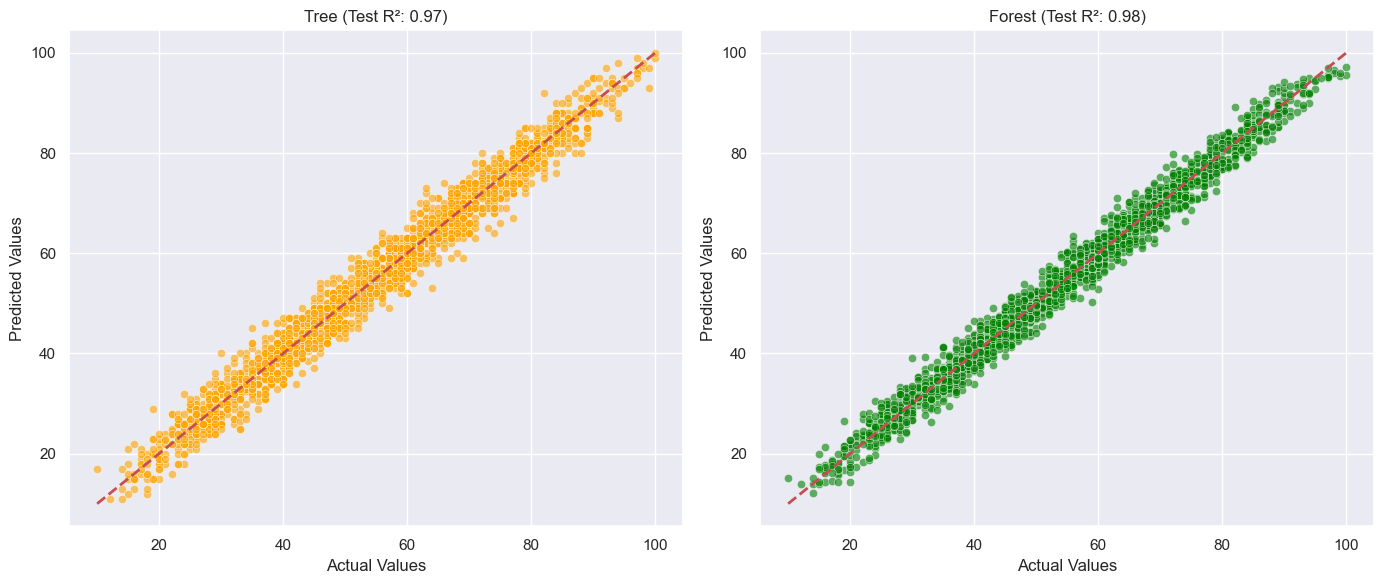

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# EXISTING IMPLENTATIONS
# 1. EVALUATE REGRESSION TREE
tree_model_exist = DecisionTreeRegressor(random_state=123)
tree_results_exist = evaluate_model(tree_model_exist, X_train, y_train, X_test, y_test)
print_results("REGRESSION TREE existing", tree_results_exist)

# 2. EVALUATE RANDOM FOREST
# (Note: Using 'seed' as per your previous message)
rf_model_exist = RandomForestRegressor(random_state=123)
rf_results_exist = evaluate_model(rf_model_exist, X_train, y_train, X_test, y_test)
print_results("RANDOM FOREST existing", rf_results_exist)

# 3. VISUAL COMPARISON
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Tree Results
sns.scatterplot(x=tree_results_exist['y_test_actual'], y=tree_results_exist['y_test_pred'], ax=axes[0], color='orange', alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title(f"Tree (Test R²: {tree_results_exist['Test_R2']:.2f})")
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")

# Plot Forest Results
sns.scatterplot(x=rf_results_exist['y_test_actual'], y=rf_results_exist['y_test_pred'], ax=axes[1], color='green', alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title(f"Forest (Test R²: {rf_results_exist['Test_R2']:.2f})")
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")

plt.tight_layout()
plt.show()